# Project 3 - Sentiment Analysis for E-Commerce Store
### by Azubuogu Peace Udoka

### Table of Content
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#data">Understanding the Dataset</a></li>
<li><a href="#visual">Data Visualisation</a></li>
<li><a href="#feat">Feature Engineering</a></li>
<li><a href="#model">Building the Model</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Background
As a data analyst at Amazon, I have access to a dataset containing product reviews and associated ratings. The task is to build a model that can classify each review as positive, negative, or neutral based on the text content.

In [7]:
# uncomment the code below to install wordcloud
# !pip install wordcloud

In [95]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from nltk import word_tokenize 
from wordcloud import WordCloud #ensure wordcloud is installed
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
#set general style of plots
sns.set(rc = {'figure.figsize':(20,8)}, style="white", font_scale=1.5)

import warnings
warnings.simplefilter("ignore")

In [ ]:
# uncomment the code below if error is raised to download punkt
# nltk.download('punkt')

<a id='data'></a>
## Understanding the Dataset


In [13]:
# load data
data = pd.read_csv('Amazon Product Review.txt')
# view 5 random rows of data
data.sample(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
11511,US,41338791,R3FP2C059JMW67,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Awesome Tablet,"This is an awesome tablet, and if you read Kin...",2015-04-15,1
22837,US,11864041,R20HKLI3GNK2R1,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Love my new Kindle Fire,Love my new Kindle Fire....it's like almost li...,2015-01-05,1
13421,US,29962681,R1TVWQLF8BNQ5Y,B00LCHOCZY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,i love my kindle fire,My #1 possession.,2015-03-14,1
25389,US,45516188,R2YBSHC08OGJMK,B00LCHS1FG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Perfect,Perfect ...,2014-12-29,1
27554,US,29418344,R2KI343GG9S9Z3,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,1,1,N,Y,Battery Power,"I love this product, however the battery power...",2014-12-15,1


In [15]:
# size of dataset
data.shape

(30846, 16)

There are 30846 rows of data and 16 columns

In [17]:
# checking for missing values
data.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      2
review_body          4
review_date          0
sentiment            0
dtype: int64

There are no missing values.

In [19]:
# checking for duplicates
data.duplicated().sum()

0

There are no dupicates.

In [81]:
# check the datatypes
data.dtypes

marketplace                  object
customer_id                  object
review_id                    object
product_id                   object
product_parent               object
product_title                object
product_category             object
star_rating                   int64
helpful_votes                 int64
total_votes                   int64
vine                         object
verified_purchase            object
review_headline              object
review_body                  object
review_date          datetime64[ns]
sentiment                     int64
dtype: object

In [53]:
# converting customer_id and product_parent column to string and review_date column to date
data['customer_id'] = data['customer_id'].astype('str')
data['product_parent'] = data['product_parent'].astype('str')
data['review_date'] = pd.to_datetime(data['review_date'])

In [55]:
# fraction of positive and negative reviews
data.sentiment.value_counts()/len(data)

sentiment
1    0.835343
0    0.164657
Name: count, dtype: float64

The sentiment column contains two values.

0 - negative sentiment

1 - positive sentiment

This means, majority of the reviews are positive (83.5343%) and 16.4657% of the reviews are negative.

<a id='visual'></a>
## Data Visualisation
<b>1. WordCloud:</b> To get a general idea of the type of reviews gotten, we will visualise the words using a wordcloud.

In [97]:
# extract only the text from html tags
data['review_body'] = data['review_body'].apply(lambda review: BeautifulSoup(review, 'html.parser').get_text() if isinstance(review, str) else '')
# remove url tags
data['review_body']=data['review_body'].apply(lambda review: re.sub(r'http\S+', '', review))

In [99]:
# convert all reviews to lowercase
data['review_body'] = data['review_body'].str.lower()
data['review_headline'] = data['review_headline'].str.lower()

# create a variable for the words in the review body. Use str() to convert any float in the text to string
word_body = " ".join(str(review) for review in data.review_body)
# create a variable for the words in the review headline
word_head = " ".join(str(review) for review in data.review_headline)

# define stopwords 
my_stop_words = ENGLISH_STOP_WORDS.union(['Amazon','product','Kindle','br','star','stars', 'tablet', 'book','app','use', 'screen','device','battery', 'apps','books','just',"I'm","don't"])

In [101]:
# create word cloud for the review body
word_cloud_1 = WordCloud(stopwords = my_stop_words, collocations = False, background_color = 'white').generate(word_body)
# create word cloud for the review headline
word_cloud_2 = WordCloud(stopwords = my_stop_words, collocations = False, background_color = 'white').generate(word_head)

### Plotting Review Body WordCloud

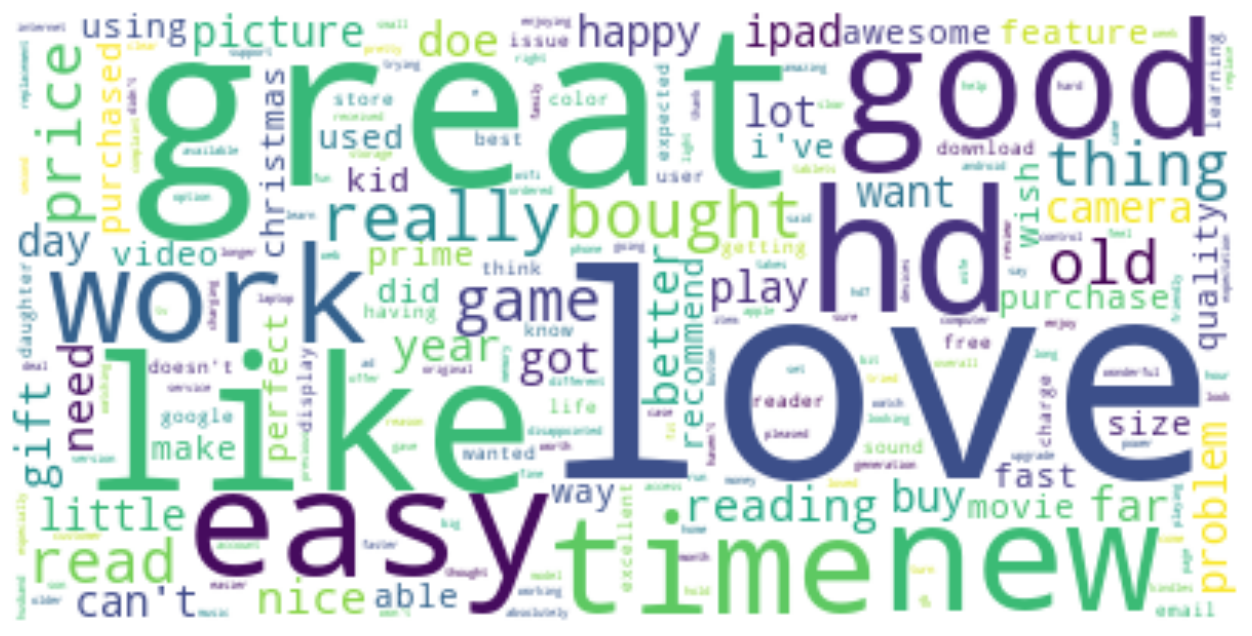

In [103]:
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Plotting Review Headline WordCloud

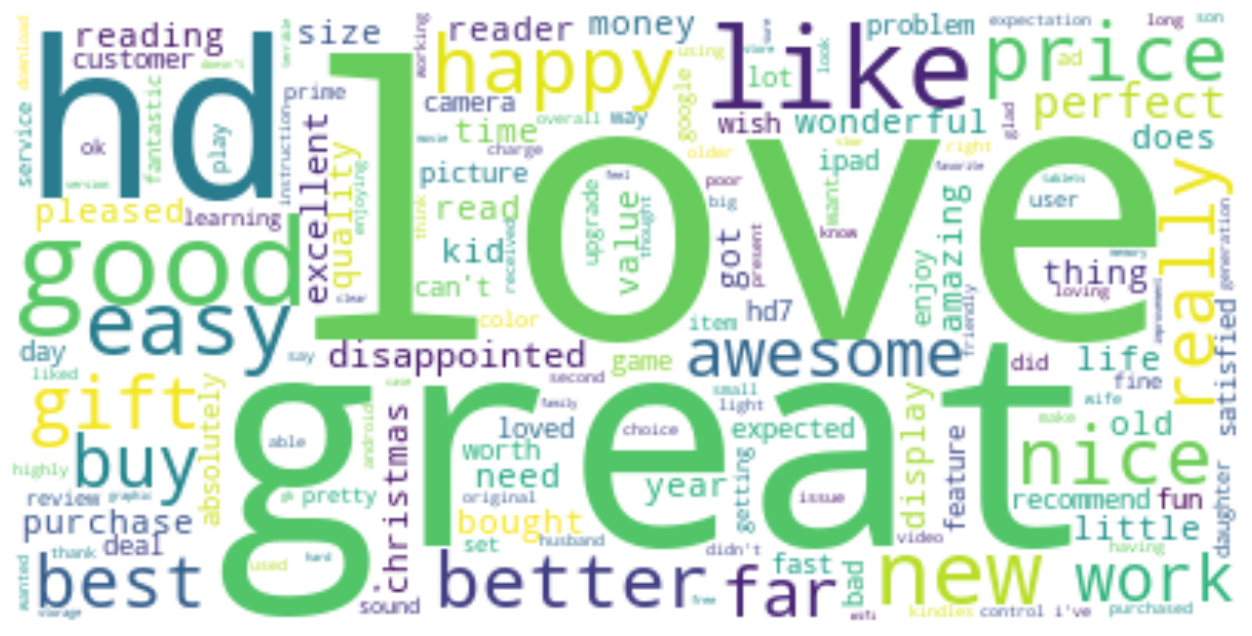

In [105]:
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()

From the wordcloud, we can agree to the percentages earlier found that most of the reviews are positive.

<b>2. Visualising Star Rating </b>

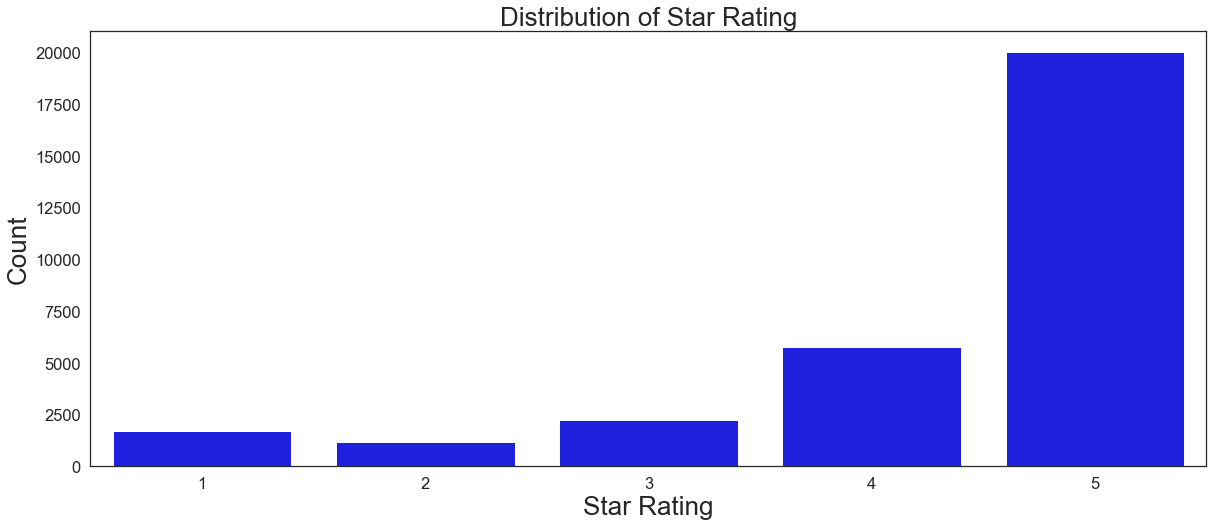

In [31]:
# plotting star ratings
sns.countplot(data = data, x = 'star_rating', color = 'blue')
plt.xlabel("Star Rating", fontsize=26);
plt.ylabel("Count", fontsize=26);
plt.title("Distribution of Star Rating", fontsize=26);

<a id='feat'></a>
## Feature Engineering


In [13]:
# create new column containing number of words from each review_body
word_tokens = [word_tokenize(review) for review in data.review_body]
# remove non alphabetic characters in token
clean_tokens = [[word for word in item if word.isalpha()] for item in word_tokens]
length = []
# add new feature to dataset 
for i in range(len(clean_tokens)):
    length.append(len(clean_tokens[i]))
data['no_of_words'] = length  



,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment,no_of_words
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1,3
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0,30
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1,114
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1,201
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1,8


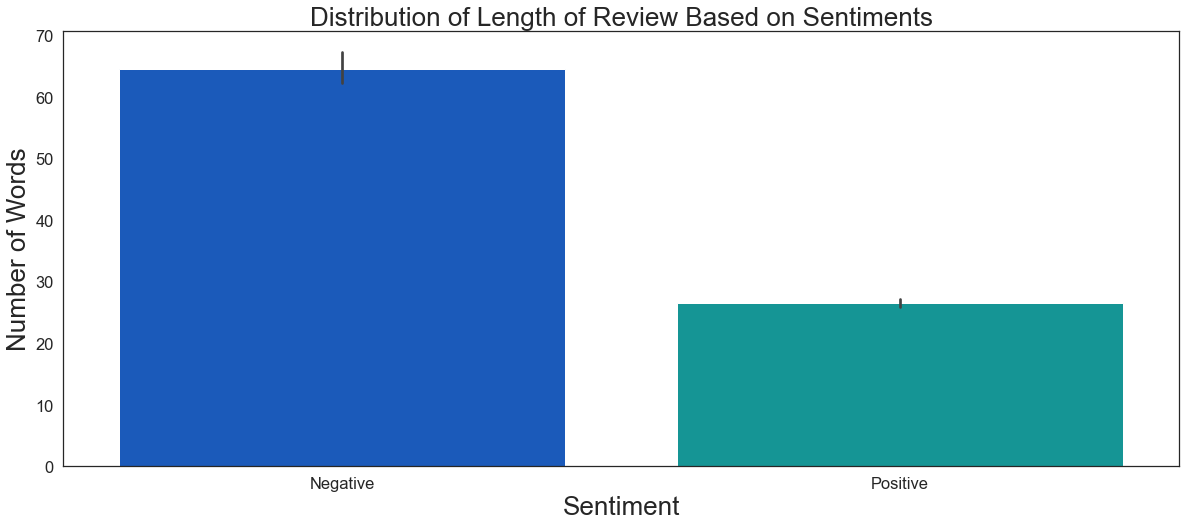

In [35]:
# plotting length of reviews
sns.barplot(data = data, x = 'sentiment', y = 'no_of_words', palette = 'winter')
plt.xticks([0, 1], ["Negative", "Positive"])
plt.xlabel("Sentiment", fontsize=26);
plt.ylabel("Number of Words", fontsize=26);
plt.title("Distribution of Length of Review Based on Sentiments", fontsize=26);

Negative reviews tend to have longer words.

<a id='model'></a>
## Building the Model

This is a classification problem so a LogisticRegression model will be used.

To build a model, the data has to be transformed to numeric features by using a vectorizer.

In [20]:
# define the vectorizer and specify the arguments
vect = TfidfVectorizer(ngram_range=(1, 3), max_features=500, token_pattern=r'\b[^\d\W][^\d\W]+\b', stop_words=ENGLISH_STOP_WORDS).fit(data.review_body)

# Transform the vectorizer
num_txt = vect.transform(data.review_body)

# Transform to a data frame and specify the column names
num_df=pd.DataFrame(num_txt.toarray(), columns=vect.get_feature_names())
num_df.head()

,ability,able,absolutely,absolutely love,access,account,actually,add,ads,ago,...,works,works great,worth,wouldn,wrong,year,year old,years,yes,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200803,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344792,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183079,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [23]:
# include the sentiment column which will the label of the model
num_df['sentiment'] = data['sentiment']

num_df.head()

,ability,able,absolutely,absolutely love,access,account,actually,add,ads,ago,...,works great,worth,wouldn,wrong,year,year old,years,yes,youtube,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200803,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344792,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183079,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


In [37]:
# define target and features
y = num_df.sentiment
X = num_df.drop('sentiment', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Build a logistic regression model and calculate the accuracy
log_reg = LogisticRegression(C = 1.50).fit(X_train, y_train)

# predicting and calculating accuracy
y_predict = log_reg.predict(X_test)
print('Accuracy score of logistic regression: ', accuracy_score(y_test, y_predict))
print('Score of logistic regression: ', log_reg.score(X_test, y_test))

Accuracy score of logistic regression:  0.8946515397082658
Score of logistic regression:  0.8946515397082658


The Model Accuracy is 89.465% so it performs well.